# Patient users

Reproducing [Path-dependence problem with EIP-1559 and a possible solution to this problem](https://mtefagh.github.io/fee/) with different demand assumptions. Contrary to this work, we do not obtain the progressive basefee decrease. The potential reason is that in the path-dependence notebooks, 500 new transactions are spawned each round, drawing at random their premium and max fee. The gas used by each transaction is 25,000, while the block gas target is 12,500,000, i.e., there is just enough demand each round to fill the block to target. The 

- Block target = 12.5M gas, block limit = 25M gas
- All users send transactions of size 25000 gas, i.e., target = 500 txs, limit = 1000 txs.
- User values (in Gwei) drawn from Pareto distribution `1 + self.rng.pareto(2) * 20`. No cost per time unit.
- On average 100 users are drawn each round, with the number following a Poisson distribution of mean 100.
- 5% of users are patient: wait at most 10 blocks for a block that is undertarget, otherwise send the transaction.
- Other users are strategic 1559: set `max_fee` to their value and the premium to 1 Gwei if the previous block premiums were all 1 Gwei, otherwise set premium to min premium in the previous block + 0.1 Gwei.
- Transaction pool keeps in memory only 500 transactions, resorted each step to keep highest fee paying transactions first.
- Simulation runs for 20,000 blocks. Basefee updated with multiplicative rule.

In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from typing import Sequence, Dict

from abm1559.utils import (
    constants,
    basefee_from_csv_history,
    get_basefee_bounds,
    flatten
)
constants["SIMPLE_TRANSACTION_GAS"] = 125000
demand_equal_target = constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"]

from abm1559.txpool import TxPool

from abm1559.users import (
    User1559,
    AffineUser,
    User
)

from abm1559.config import rng

from abm1559.txs import Transaction, Tx1559, TxLegacy

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
    Block
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
    generate_gbm,
)

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 50)
import numpy as np
import time
import seaborn as sns
from tqdm import tqdm

In [2]:
class StrategicUser(User1559):
    
    epsilon = 0.1 # how much the user overbids by

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 20) * (10 ** 9)
        self.transacted = False

    def decide_parameters(self, env):
        if env["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = env["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }
        
    def create_transaction(self, env):
        if self.transacted:
            return None
        
        tx = super().create_transaction(env)
        if not tx is None:
            tx.gas_used = constants["SIMPLE_TRANSACTION_GAS"]
            self.transacted = True
        return tx
    
    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

In [3]:
class PatientUser(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = (1 + self.rng.pareto(2) * 20) * (10 ** 9)
        self.patience = 10
        self.transacted = False
        
    def update_patience(self):
        self.patience = self.patience - 1
        
    def create_transaction(self, env):
        if self.transacted:
            return None
        
        if self.patience == 0 or env["is_full"]:
            tx = super().create_transaction(env)
            if tx is not None:
                tx.gas_used = constants["SIMPLE_TRANSACTION_GAS"]
                self.transacted = True
            return tx
        else:
            self.update_patience()
            return None

In [4]:
class PatientUserPool(UserPool):
    
    def decide_transactions(self, users: Sequence[User], env: Dict, query_all: bool = False) -> Sequence[Transaction]:
        txs = []
        for user in users:
            self.users[user.pub_key] = user
        
        self.users = { pub_key: user for pub_key, user in self.users.items() if user.wakeup_block >= env["current_block"] - 20 }
        
        # We first ask non-patient users if they'd like to transact
        for user in self.users.values():
            if type(user) is StrategicUser:
                tx = user.transact(env)
                if not tx is None:
                    txs.append(tx)
        
        # Simulate a block being built by a miner to determine the gas used by the next block
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in txs if tx.is_valid(env)]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]
        
        # If gas used is more than half of the block, patient users transact
        env["is_full"] = len(selected_txs) >= max_tx_in_block // 2
        
        for user in self.users.values():
            if type(user) is PatientUser:
                tx = user.transact(env)
                if not tx is None:
                    txs.append(tx)
                    
        return txs

In [5]:
MAX_TRANSACTIONS_IN_POOL = 500
MIN_ACCEPTABLE_TIP = 1e9

class MixedTxPool(TxPool):
    
    def add_txs(self, txs: Sequence[Transaction], env: dict) -> Sequence[Transaction]:
        for tx in txs:
            self.txs[tx.tx_hash] = tx
                
        if self.pool_length() > MAX_TRANSACTIONS_IN_POOL:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:MAX_TRANSACTIONS_IN_POOL], env)
            return sorted_txs[MAX_TRANSACTIONS_IN_POOL:]
        
        return []
    
    def select_transactions(self, env, user_pool=None, rng=rng) -> Sequence[Transaction]:
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= MIN_ACCEPTABLE_TIP]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

In [6]:
def update_basefee_additive(block: Block, basefee: int) -> int:
    """
    Basefee update rule

    Args:
        block (Block): The previous block
        basefee (int): The current basefee

    Returns:
        int: The new basefee
    """

    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    new_basefee = max(0, basefee + (2 ** 30) * delta / constants["TARGET_GAS_USED"] / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"])
    return new_basefee

In [7]:
def simulate(demand_scenario, shares_scenario, extra_metrics = None, rng = rng, additive_rule = False):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = PatientUserPool()
    start_time = time.time()
    block_target = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"] / 2.0)
    
    # `env` is the "environment" of the simulation
    env = {
        "basefee": constants["INITIAL_BASEFEE"],
        "current_block": None,
        "min_premium": 1 * (10 ** 9),
        "is_full": False
    }

    for t in tqdm(range(len(demand_scenario))):
        # Sets current block
        env["current_block"] = t
        
        # Reset the random number generator with new seed to generate users with same values across runs
        rng = np.random.default_rng(t)
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t], rng=rng)

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env, query_all=True)
        
        patient_sent = len([tx for tx in decided_txs if type(user_pool.get_user(tx.sender)) is PatientUser])

        txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, basefee = env["basefee"]
        )
        
        # Record the min premium in the block
        env["min_premium"] = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)
        
        ### METRICS ###
                
        row_metrics = {
            "block": t,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "basefee": env["basefee"] / (10 ** 9), # to Gwei
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_max_premium": block.max_premium() / (10 ** 9), # to Gwei
            "blk_min_tip": block.min_tip(env) / (10 ** 9), # to Gwei
            "blk_max_tip": block.max_tip(env) / (10 ** 9), # to Gwei
            "patient_sent": patient_sent,
        }
        
        if not extra_metrics is None:
            row_metrics = {
                **row_metrics,
                **extra_metrics(env, users, user_pool, txpool),
            }
        
        metrics.append(row_metrics)
        
        # Finally, basefee is updated and a new round starts
        if additive_rule:
            env["basefee"] = update_basefee_additive(block, env["basefee"])
        else:
            env["basefee"] = update_basefee(block, env["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)

## Demand equal to target, no patient users, multiplicative rule

In [11]:
blocks = 1000

# Number of new users per time step
demand_scenario = [demand_equal_target for t in range(blocks)]

# Shares of new users per time step
shares_scenario = [{
    StrategicUser: 1.0,
} for t in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

100%|██████████| 1000/1000 [01:07<00:00, 14.89it/s]


Text(0, 0.5, 'Gas price (Gwei)')

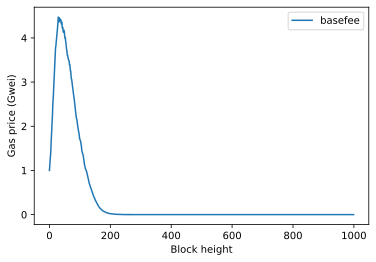

In [12]:
ax = df.plot("block", ["basefee"])
ax.set_xlabel("Block height")
ax.set_ylabel("Gas price (Gwei)")

In [13]:
df

,block,users,decided_txs,included_txs,basefee,blk_min_premium,blk_max_premium,blk_min_tip,blk_max_tip,patient_sent
0,0,206,189,189,1.000000e+00,1.1,1.1,1.1,1.1,0
1,1,200,173,173,1.111250e+00,1.2,1.2,1.2,1.2,0
2,2,190,158,158,1.212652e+00,1.3,1.3,1.3,1.3,0
3,3,176,150,150,1.300569e+00,1.4,1.4,1.4,1.4,0
4,4,229,202,200,1.381854e+00,1.5,1.5,1.5,1.5,0
...,...,...,...,...,...,...,...,...,...,...
995,995,178,1,1,8.000000e-09,100.5,100.5,100.5,100.5,0
996,996,185,6,6,8.000000e-09,100.6,100.6,100.6,100.6,0
997,997,202,7,7,8.000000e-09,100.7,100.7,100.7,100.7,0
998,998,208,9,9,8.000000e-09,100.8,100.8,100.8,100.8,0


## Demand equal to target, 5% patient users, multiplicative rule

In [14]:
# Number of new users per time step
demand_scenario = [demand_equal_target for t in range(blocks)]

# Shares of new users per time step
shares_scenario = [{
    PatientUser: 0.05,
    StrategicUser: 0.95,
} for t in range(blocks)]

(df2, user_pool, chain) = simulate(demand_scenario, shares_scenario)

100%|██████████| 1000/1000 [00:43<00:00, 22.88it/s]


Text(0, 0.5, 'Gas price (Gwei)')

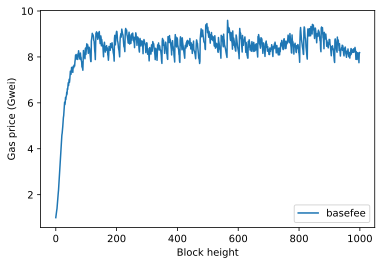

In [15]:
ax = df2.plot("block", ["basefee"])
ax.set_xlabel("Block height")
ax.set_ylabel("Gas price (Gwei)")

In [16]:
df2

,block,users,decided_txs,included_txs,basefee,blk_min_premium,blk_max_premium,blk_min_tip,blk_max_tip,patient_sent
0,0,206,189,189,1.000000,1.0,1.1,1.0,1.1,9
1,1,200,175,175,1.111250,1.0,1.1,1.0,1.1,10
2,2,190,162,162,1.215430,1.0,1.1,1.0,1.1,9
3,3,176,153,153,1.309625,1.0,1.1,1.0,1.1,7
4,4,229,207,200,1.396388,1.0,1.1,1.0,1.1,9
...,...,...,...,...,...,...,...,...,...,...
995,995,178,87,87,8.162853,1.1,1.1,1.1,1.1,0
996,996,185,72,72,8.030207,1.2,1.2,1.2,1.2,0
997,997,202,139,140,7.749150,1.0,1.3,1.0,1.3,17
998,998,208,105,105,8.136607,1.0,1.1,1.0,1.1,4


## Demand larger than target, 5% patient users, multiplicative rule

In [17]:
# Number of new users per time step
demand_scenario = [int(demand_equal_target * 1.6) for t in range(blocks)]

# Shares of new users per time step
shares_scenario = [{
    PatientUser: 0.05,
    StrategicUser: 0.95,
} for t in range(blocks)]

(df3, user_pool, chain) = simulate(demand_scenario, shares_scenario)

100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


Text(0, 0.5, 'Gas price (Gwei)')

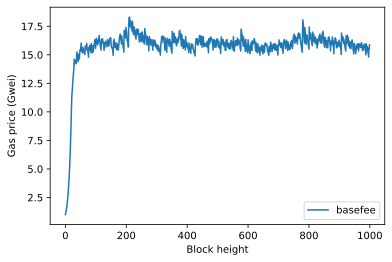

In [18]:
ax = df3.plot("block", ["basefee"])
ax.set_xlabel("Block height")
ax.set_ylabel("Gas price (Gwei)")

## Demand equal to target, 5% patient users, additive rule

In [8]:
# Number of new users per time step
demand_scenario = [demand_equal_target for t in range(blocks)]

# Shares of new users per time step
shares_scenario = [{
    PatientUser: 0.05,
    StrategicUser: 0.95,
} for t in range(blocks)]

(df4, user_pool, chain) = simulate(demand_scenario, shares_scenario, additive_rule = True)

100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]


Text(0, 0.5, 'Gas price (Gwei)')

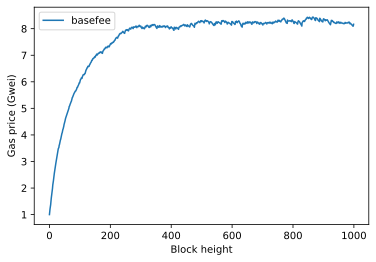

In [9]:
ax = df4.plot("block", ["basefee"])
ax.set_xlabel("Block height")
ax.set_ylabel("Gas price (Gwei)")

In [10]:
df4

,block,users,decided_txs,included_txs,basefee,blk_min_premium,blk_max_premium,blk_min_tip,blk_max_tip,patient_sent
0,0,206,189,189,1.000000,1.0,1.1,1.0,1.1,9
1,1,200,174,174,1.119454,1.0,1.1,1.0,1.1,10
2,2,190,162,162,1.218775,1.0,1.1,1.0,1.1,9
3,3,176,153,153,1.301990,1.0,1.1,1.0,1.1,7
4,4,229,207,200,1.373125,1.0,1.1,1.0,1.1,9
...,...,...,...,...,...,...,...,...,...,...
995,995,178,99,99,8.129646,1.1,1.1,1.1,1.1,0
996,996,185,72,72,8.128304,1.2,1.2,1.2,1.2,0
997,997,202,152,110,8.090723,1.3,1.3,1.3,1.3,42
998,998,208,104,146,8.104144,1.0,1.4,1.0,1.4,4
